<a href="https://colab.research.google.com/github/barronh/aqmbc/blob/master/aqmbc_geosv12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Convert GEOS-Chem to CMAQ-ready Boundary Conditions

    author: Barron H. Henderson
    date: 2020-03-13
    summary: Use benchmark file to make boundary conditions.

# Overview of aqmbc Repository

* This repository is for making Air Quality Model Boundary Conditions
  * Really it makes CMAQ-ready boundaries
  * CAMx has a converter to go from CMAQ-ready to CAMx-ready.
* aqmbc is python-code that depends on `PseudoNetCDF` to:
  * Spatial interpolation (nearest neighbor)
  * Vertical interpolation (linear for GEOS-Chem; to add mass conserving)
  * Species translation 
  * and CMAQ IOAPI meta data "decoration"
* Species translations are in `definitions/`
  * Please add and update!
  * If you do, please submit them for the package to get updated

# Download the aqmbc repo

* Using wget to download
* and unzip to prepare

In [0]:
%%bash
wget -q https://github.com/barronh/aqmbc/archive/master.zip
unzip -q master.zip

# Install Pre-requisites

* pyproj is an optional requirement for PseudoNetCDF, but necessary for spatial interpolation.
* PseudoNetCDF provides convenience functions like ll2ij and interpSigma
  * using GC netCDF requires an update to PseudoNetCDF that is not yet in the main branch.


In [0]:
%%bash
pip install -q pyproj
pip install -q --no-cache https://github.com/barronh/pseudonetcdf/archive/bugfix/gcnc-interpsigma.zip

# Update the working directory

* The rest of the notebook focuses on aqmbc
* we use cd in the workbook to move there

In [3]:
cd aqmbc-master

/content/aqmbc-master


# Get a GEOS-Chem NetCDF file

* Using the v12.7 monthly benchmark output
  * Also works with SpeciesBC or any other output
  * As long as the definitions match the content.
* Downloading with wget to teh aqmbc-master/CONC folder

In [0]:
%%bash
cd /content/aqmbc-master/CONC
wget -q http://ftp.as.harvard.edu/gcgrid/geos-chem/1mo_benchmarks/GC_12/12.7.0/GCC/OutputDir/GEOSChem.SpeciesConc.20160701_0000z.nc4

# Test Grid

* The standard grids are provided for convenience
  * the 12km Continental US domain (12US1)
  * the 36km North American domain (36US3)
  * the 108km Polar Stereographic domain (108NHEMI2)
* All are too large for a quick tutorial
* We'll use the 144km North American domain (TEST)


In [5]:
cat GRIDDESC

' '
'POLSTE_HEMI'
  6         1.000        45.000       -98.000       -98.000        90.000
'LamCon_40N_97W'
  2        33.000        45.000       -97.000       -97.000        40.000
' '
'HEMI_187_187'
'POLSTE_HEMI' -10098000.000 -10098000.000    108000.000    108000.000 187 187   1
'36US3'
'LamCon_40N_97W'  -2952000.000  -2772000.000     36000.000     36000.000 172  148   1
'12US1'
'LamCon_40N_97W'     -2556000.0 -1728000.0 12000.0 12000.0 459 299 1
'12US2'
'LamCon_40N_97W'     -2412000.0 -1620000.0 12000.0 12000.0 396 246 1
'TEST'
'LamCon_40N_97W'  -2952000.000  -2772000.000    144000.000    144000.000 43  37   1
' '


# Run AQMBC

Goal: Run a simple test case.

* Set GRID to the TEST grid we defined
* Set the file pattern to find the SpeciesConc file
* Add options
  * expressiosn (`--expr`) for gas species translation (aerosols pending)
  * interpolation method (`--interp linear`)
  * file format (`--format gcnc`)
  * and a translator for dimensions
* Some options may seem unnecessary, but aqmbc works on many file formats.

Notes: 
* This step will take a minute or so. Coffee break! 
* On your server, you can run much bigger domains.

In [0]:
%%bash
export GRID=TEST

# Run all or bcon or combine or fig
export FILEPAT='GEOSChem.SpeciesConc.*'
export BCOPTS="--expr ../definitions/gc/gc12_to_cb6r3.expr --interp linear --format gcnc --dimkeys COL=lon,ROW=lat,LAY=lev,TSTEP=time"
make bcon >& bcon.log


# Visualize CMAQ-Ready BCON

Goal: To see what aqmbc made.

* Use PseudoNetCDF plot function to make a panel
* Add ticks to make the layout clear
* once for Ozone and once for NOx

In [0]:
import PseudoNetCDF as pnc
import numpy as np
import matplotlib.colors as mc
import matplotlib.pyplot as plt

[]

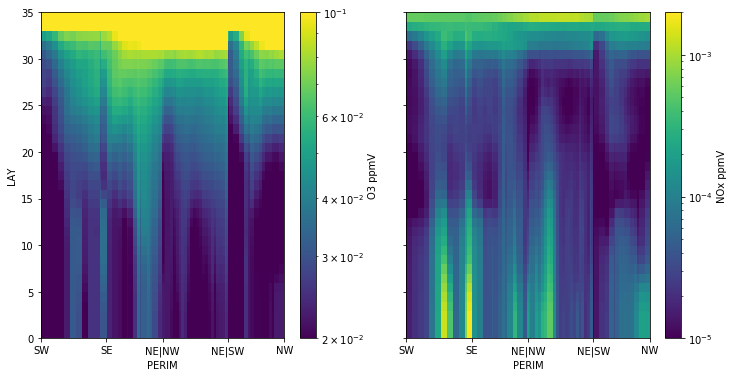

In [8]:
fig, axx = plt.subplots(1, 2, figsize=(12,6))
bconf = pnc.pncopen('BCON/GEOSChem.SpeciesConc.20160701_0000z.nc4.BCON.nc', format='ioapi')
plt.sca(axx[0])
o3ax = bconf.plot('O3', plottype='PERIM-LAY', plot_kw=dict(norm=mc.LogNorm(vmin=0.02, vmax=0.1)))
plt.sca(axx[1])
noxax = bconf.eval('NOx = NO[:] + NO2[:]').plot('NOx', plottype='PERIM-LAY', plot_kw=dict(norm=mc.LogNorm(vmin=1e-5, vmax=2e-3)))

# See https://www.cmascenter.org/ioapi/documentation/all_versions/html/BDY.jpg
for ax in axx:
  ax.set_xticks(np.cumsum([0, bconf.NCOLS + 1, bconf.NROWS + 1, bconf.NCOLS + 1, bconf.NROWS + 1]))
  ax.set_xticklabels(['SW', 'SE', 'NE|NW', 'NE|SW', 'NW'], horizontalalignment='center');

axx[1].set_ylabel('')
axx[1].set_yticklabels('')

# Make a Similar plot from GEOS-Chem

Goal: To spot check that the processing makes noinal sense.

* Open the original file
* Make a 4-panel figure
  * make representative slices of the file
  * plot them on each axes
* Then, restrict GEOS-Chem to similar top pressure

Note:
1. These won't look the same as CMAQ
2. CMAQ has more vertical layer in the near-surface and less in the upper troposphere.
3. CMAQ is extracting along a curvilinear space, so the grid cells are not actually a line. This is a rough approximation.

In [0]:
origf = pnc.pncopen('/content/aqmbc-master/CONC/GEOSChem.SpeciesConc.20160701_0000z.nc4', format='gcnc')

**PNC:/usr/local/lib/python3.6/dist-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  Values are out of bounds:
[]


Ignore warning


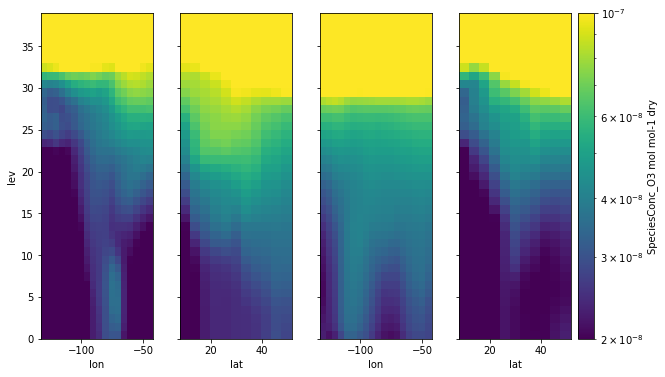

In [10]:
minj, maxj = origf.val2idx('lat', [10, 50])
mini, maxi = origf.val2idx('lon', [-130, -45])
print('Ignore warning')
fig, axx = plt.subplots(1, 4, figsize=(10, 6), gridspec_kw=dict(wspace=0.0))
southf = origf.slice(lat=minj, lon=slice(mini, maxi + 1))
eastf = origf.slice(lat=slice(minj, maxj + 1), lon=maxi)
northf = origf.slice(lat=maxj, lon=slice(mini, maxi + 1))
westf = origf.slice(lat=slice(minj, maxj + 1), lon=mini)

for f in [southf, eastf, westf, northf]:
    del f.variables['lev']

plt.sca(axx[0])
southf.plot('SpeciesConc_O3', plottype='lon-lev', plot_kw=dict(norm=mc.LogNorm(vmin=0.02e-6, vmax=0.1e-6)))
plt.sca(axx[1])
eastf.plot('SpeciesConc_O3', plottype='lat-lev', plot_kw=dict(norm=mc.LogNorm(vmin=0.02e-6, vmax=0.1e-6)))
plt.sca(axx[2])
northf.plot('SpeciesConc_O3', plottype='lon-lev', plot_kw=dict(norm=mc.LogNorm(vmin=0.02e-6, vmax=0.1e-6)))
plt.sca(axx[3])
westf.plot('SpeciesConc_O3', plottype='lat-lev', plot_kw=dict(norm=mc.LogNorm(vmin=0.02e-6, vmax=0.1e-6)))

for ax in axx:
  ax.set_ylim(0, 39)


plt.setp(fig.axes[-4:-1], visible=False)
plt.setp(fig.axes[1:4], ylabel='', yticklabels='');

# More on your own.

* you can plot any of the other species
* aqmbc makes lateral and initial boundary conditions. To view the surface level, use `iconf.slice(LAY=0).plot('O3')`.